In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
import os
OPENAI_KEY = os.environ.get("OPENAI_API_KEY")
BRIGHT_DATA_SERP_API_KEY = os.environ.get("BRIGHT_DATA_SERP_API_KEY")

assert OPENAI_KEY, "Missing OPENAI_API_KEY in .env"
assert BRIGHT_DATA_SERP_API_KEY, "Missing BRIGHT_DATA_SERP_API_KEY in .env"

In [2]:
from langchain_brightdata import BrightDataSERP

serp_tool = BrightDataSERP(
    bright_data_api_key=BRIGHT_DATA_SERP_API_KEY,
    zone="serp_api3",          # ✅ must match your BrightData dashboard
    search_engine="google",
    country="us",
    parse_results=True
)

'{"general":{"search_engine":"google","query":"Top 5 subreddits for music awards","results_cnt":140000000,"search_time":0.46,"language":"en","location":"United States","mobile":false,"basic_view":false,"search_type":"text","page_title":"Top 5 subreddits for music awards - Google Search","timestamp":"2026-02-28T13:17:25.592Z"},"input":{"original_url":"https://www.google.com/search?q=Top+5+subreddits+for+music+awards&gl=us&hl=en&brd_json=1","request_id":"hl_f518aa62_0wa4qkoqzsy"},"navigation":[{"title":"AI Mode","href":"https://www.google.com/search?q=Top+5+subreddits+for+music+awards&sca_esv=643cd21dc826a565&gl=us&hl=en&udm=50&fbs=ADc_l-aN0CWEZBOHjofHoaMMDiKpV6Bbbmx4QVaoKkiRQ2jlwvCHF0Eqz8cUq4JjDCZnrJEJPua1MxnlJWIzg-ca3uHtTQD1VZZ9C4iyPeR_GGbWNiEi9POoUn3F-OPsd86GOSzvsk_dvtu30E_vbZaO72tjv0uOjGZIUb7e0JT9DPFg6CenNfrHhR6QJ6EMzk2qy3kcYMw0FR1knddgJxB7C9r0xyyBfg&aep=1&ntc=1&sa=X&ved=2ahUKEwjL7qblovySAxWcrpUCHWqLLL8Q2J8OegQIDxAE"},{"title":"Short videos","href":"https://www.google.com/search?sca_
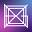
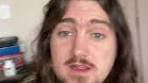
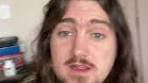

In [3]:
serp_tool.invoke("Top 5 subreddits for music awards")

In [12]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    model="gpt-5-nano",
    api_key=OPENAI_KEY,
    max_tokens=800,      
    temperature=0
)

In [13]:
from langchain_core.tools import Tool

def google_search(query: str) -> str:
    # IMPORTANT: pass a plain string so the tool uses your configured zone="serp_api3"
    return serp_tool.invoke(query)

search_tool = Tool(
    name="google_search",
    description="Search Google via BrightData SERP. Input is a plain query string.",
    func=google_search
)

In [14]:
import json, time
from langchain_core.messages import ToolMessage

tools = [search_tool]
tool_mapping = {t.name: t for t in tools}

llm_with_tools = model.bind_tools(tools, tool_choice="any")  # force tool use while testing

def ask_agent_once(question: str) -> str:
    # Call 1: model generates tool call
    ai_msg = llm_with_tools.invoke(
        f"Use google_search exactly once. Keep query short.\nQuestion: {question}"
    )

    if not getattr(ai_msg, "tool_calls", None):
        return ai_msg.content or "(no content returned in first call)"

    messages = [ai_msg]

    # Execute tool call
    for call in ai_msg.tool_calls:
        tool_name = call["name"]
        tool_args = call["args"]
        tool_id = call["id"]

        # normalize args
        if isinstance(tool_args, dict):
            query = tool_args.get("query") or tool_args.get("input") or next(iter(tool_args.values()))
        else:
            query = str(tool_args)

        tool_result = tool_mapping[tool_name].invoke(query)

        messages.append(
            ToolMessage(
                content=tool_result if isinstance(tool_result, str)
                        else json.dumps(tool_result, ensure_ascii=False),
                tool_call_id=tool_id
            )
        )

    time.sleep(0.7)

    # Call 2: final answer (NO TOOLS)
    final = model.invoke(
        messages + [
            {"role": "user", "content": "Answer using ONLY the search results above. "
                                        "Include one source link. Do NOT call any tools."}
        ]
    )

    return final.content or "(no final content returned)"

In [15]:
ask_agent_once("Find the latest Tesla (TSLA) stock price and cite the source.")

'(no final content returned)'

In [16]:
print("Tool name:", search_tool.name)
print("Tool description:", search_tool.description)

Tool name: google_search
Tool description: Search Google via BrightData SERP. Input is a plain query string.


In [17]:
tools = [search_tool]
tool_mapping = {t.name: t for t in tools}

llm_with_tools = model.bind_tools(tools, tool_choice="any")  # force tool call
ai_msg = llm_with_tools.invoke("Use google_search exactly once to search: TSLA stock price. Then stop.")
print("content:", repr(ai_msg.content))
print("tool_calls:", getattr(ai_msg, "tool_calls", None))

content: ''
tool_calls: [{'name': 'google_search', 'args': {'__arg1': 'TSLA stock price'}, 'id': 'call_mx9F8wkKVhx4JnSdwIcfFuxa', 'type': 'tool_call'}]


In [18]:
import json, time
from langchain_core.messages import ToolMessage

def ask_agent_once(question: str) -> str:
    # Call 1 (tool-enabled)
    ai_msg = llm_with_tools.invoke(
        f"You MUST call google_search exactly once.\nSearch query: {question}"
    )

    tool_calls = getattr(ai_msg, "tool_calls", None)
    if not tool_calls:
        # show what happened instead of silently failing
        return f"(no tool_calls; content={repr(ai_msg.content)})"

    messages = [ai_msg]

    # Execute tool call(s)
    for call in tool_calls:
        tool_name = call["name"]
        tool_args = call["args"]
        tool_id = call["id"]

        if isinstance(tool_args, dict):
            query = tool_args.get("query") or tool_args.get("input") or next(iter(tool_args.values()))
        else:
            query = str(tool_args)

        tool_result = tool_mapping[tool_name].invoke(query)

        messages.append(
            ToolMessage(
                content=tool_result if isinstance(tool_result, str)
                        else json.dumps(tool_result, ensure_ascii=False),
                tool_call_id=tool_id
            )
        )

    time.sleep(0.7)

    # Call 2 (NO tools)
    final = model.invoke(
        messages + [
            {"role": "user", "content": "Now answer using ONLY the search results above. "
                                        "Include one source link. Do NOT call any tools."}
        ]
    )

    return final.content or "(no final content returned)"

In [19]:
ask_agent_once("TSLA stock price")


'(no final content returned)'

In [40]:
import os
from dotenv import load_dotenv
load_dotenv()

from langgraph.prebuilt import create_react_agent

OPENAI_KEY = os.environ.get("OPENAI_API_KEY")
BRIGHT_DATA_SERP_API_KEY = os.environ.get("BRIGHT_DATA_SERP_API_KEY")

assert OPENAI_KEY, "Missing OPENAI_API_KEY"
assert BRIGHT_DATA_SERP_API_KEY, "Missing BRIGHT_DATA_SERP_API_KEY"

# --- BrightData SERP tool ---
from langchain_brightdata import BrightDataSERP

serp_tool = BrightDataSERP(
    bright_data_api_key=BRIGHT_DATA_SERP_API_KEY,
    zone="serp_api3",
    search_engine="google",
    country="us",
    parse_results=True
)

# --- Wrap tool (prevents zone/arg injection) ---
from langchain_core.tools import tool

@tool
def google_search(query: str) -> str:
    """Search Google via BrightData SERP. Input is a plain query string."""
    return serp_tool.invoke(query)

# --- OpenAI model (DO NOT COMMENT THIS OUT) ---
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    model="gpt-5-nano",
    api_key=OPENAI_KEY,
    max_tokens=800,
    temperature=0
)

agent_prompt = """
You are an expert assistant that can search the internet to find the best Reddit communities for any given topic.
You are also an expert at finding niche communities that discuss the same topic.

Rules:
- Use google_search when needed.
- Return a short list of subreddit suggestions with links.
"""

#  Create agent
reddit_agent = create_react_agent(
    model=model,
    tools=[google_search],
    prompt=agent_prompt
)

C:\Users\marvi\AppData\Local\Temp\ipykernel_15200\3920519219.py:52: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  reddit_agent = create_react_agent(


In [41]:
result = reddit_agent.invoke(
    {
        "messages": [
            {"role": "user", "content": "Find the best subreddits for python, javascript, django, web development"}
        ]
    }
)

final_answer = result["messages"][-1].content
print(final_answer)

{'messages': [HumanMessage(content='Find the best subreddits for python, javascript, django, web development', additional_kwargs={}, response_metadata={}, id='40905a1f-fb37-4d63-b456-07676a63ae05'), AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 420, 'prompt_tokens': 207, 'total_tokens': 627, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 320, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-DEEhnodbVFCkXjwyzZ7ZfDTkkAWZB', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019ca472-7b31-7713-a1c5-36675bc89564-0', tool_calls=[{'name': 'google_search', 'args': {'query': 'best subreddits Python programming'}, 'id': 'call_qm6VKylFHJLzxwDKzXUcs1KJ', 'type': 'tool_call'}, {
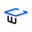
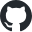
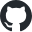
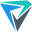
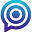
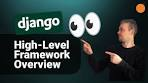
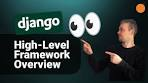
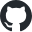
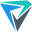
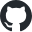
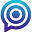
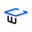
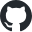
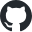
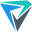
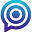
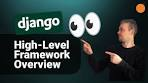
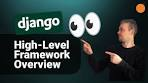
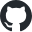
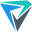
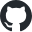
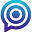

In [42]:
print(result)
for i, msg in enumerate(result["messages"]):
    print("Message", i)
    print(type(msg))
    print("Content:", msg.content)
    print("-----")

In [ ]:
import json
from langchain_core.messages import ToolMessage

def ask_agent_final(question: str) -> str:
    ai_msg = llm_with_tools.invoke(question)

    if not getattr(ai_msg, "tool_calls", None):
        return ai_msg.content or "(no content from first call)"

    messages = [ai_msg]

    for call in ai_msg.tool_calls:
        tool_name = call["name"]
        tool_args = call["args"]
        tool_id   = call["id"]

        tool = tool_mapping[tool_name]

        # normalize args -> string query
        if isinstance(tool_args, dict):
            query = tool_args.get("query") or tool_args.get("input") or next(iter(tool_args.values()))
        else:
            query = str(tool_args)

        tool_result = tool.invoke(query)

        tool_text = tool_result if isinstance(tool_result, str) else json.dumps(tool_result, ensure_ascii=False)
        tool_text = tool_text[:12000]  # <<< KEY FIX

        messages.append(ToolMessage(content=tool_text, tool_call_id=tool_id))

    # FINAL: use base model (no bind_tools) to force an answer
    final = model.invoke(
        messages + [{
            "role": "user",
            "content": (
                "Now write the final answer using ONLY the tool results above.\n"
                "Return a short bullet list of subreddits with links.\n"
                "Do NOT call any tools."
            )
        }]
    )

    return final.content or "(no final answer from writer call)"
print(ask_agent_final("Find the best subreddits for python, javascript, django, web development"))